In [1]:
%matplotlib inline  
from fastai.vision import *
from fastai.data_block import _maybe_squeeze
from fastai.callbacks import *
from sklearn.model_selection import StratifiedKFold
from joblib import load, dump
from ranger import *
from mxresnet import *

Mish activation loaded...


In [2]:
def strt_split(x, y, n_folds=10, random_seed = 42, path=Path('')):  
    try: 
        val_name = load('val_idx_10.joblib')
    except:
        skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_seed)
        val_name = [(val_idx, trn_idx) for trn_idx, val_idx in skf.split(x, y)]
        dump(val_name,'val_idx_10.joblib')
    return val_name

def modified_label_from_df(self, cols:IntsOrStrs=1, label_cls:Callable=None, **kwargs):
    "Label `self.items` from the values in `cols` in `self.inner_df`."
    self.inner_df.labels.fillna('', inplace=True)
    labels = self.inner_df.iloc[:,df_names_to_idx(cols, self.inner_df)]
    assert labels.isna().sum().sum() == 0, f"You have NaN values in column(s) {cols} of your dataframe, please fix it."
    if is_listy(cols) and len(cols) > 1 and (label_cls is None or label_cls == MultiCategoryList):
        new_kwargs,label_cls = dict(one_hot=True, classes= cols),MultiCategoryList
        kwargs = {**new_kwargs, **kwargs}
    return self._label_from_list(_maybe_squeeze(labels), label_cls=label_cls, **kwargs)


def flattenAnneal(learn:Learner, lr:float, n_epochs:int, start_pct:float, SUFFIX = 'PHASE_1_COS'):
    n = len(learn.data.train_dl)
    anneal_start = int(n*n_epochs*start_pct)
    anneal_end = int(n*n_epochs) - anneal_start
    phases = [TrainingPhase(anneal_start).schedule_hp('lr', lr),
             TrainingPhase(anneal_end).schedule_hp('lr', lr, anneal=annealing_cos)]
    sched = GeneralScheduler(learn, phases)
    learn.callbacks.append(sched)
    learn.callbacks.append(SaveModelCallback(learn, every='improvement', monitor='valid_loss', name = f'{EXP_NAME}_{SUFFIX}'))
    learn.fit(n_epochs)

In [3]:
PATH = Path('..')
BS =            480
SZ =            224
FOLD =6
EXP_NAME =      f'NB_EXP_70_CV_{FOLD}_{SZ}'
IMG_TRAIN_224 = PATH/f'train_images_3chn_sasan_{SZ}'
IMG_TEST_224  = PATH/f'test_images_3chn_sasan_{SZ}'
DF_TRAIN =      pd.read_csv(PATH/'train_labels_as_strings.csv')
DF_SUBMI =      pd.read_csv(PATH/'stage_1_sample_submission.csv')



DF_SUBMI['fn'] = DF_SUBMI.ID.apply(lambda x: '_'.join(x.split('_')[:2]) + '.png')
DF_TRAIN['labels'].fillna('', inplace=True)
VAL_IDX = strt_split(DF_TRAIN['fn'], DF_TRAIN['labels'])[FOLD]

In [4]:
ItemList.label_from_df = modified_label_from_df
test_fns = DF_SUBMI.fn.unique()
tfms = get_transforms(max_rotate=360, flip_vert=True, max_zoom=1.5, )

data = (ImageList.from_csv('..', 'train_labels_as_strings.csv', folder=IMG_TRAIN_224.name)
        .split_by_idxs(valid_idx=VAL_IDX[0], train_idx=VAL_IDX[1])
        .label_from_df(label_delim=' ')
        .transform(tfms = tfms,size=SZ)
        .add_test('../' +IMG_TEST_224.name + '/' + test_fns)
        .databunch(bs=BS)
        .normalize())

        

In [5]:
md_xrsa =  mxresnet50(c_out=data.c, sa=True)
opt_func = partial(Ranger, betas=(0.92,0.99), eps=1e-6)

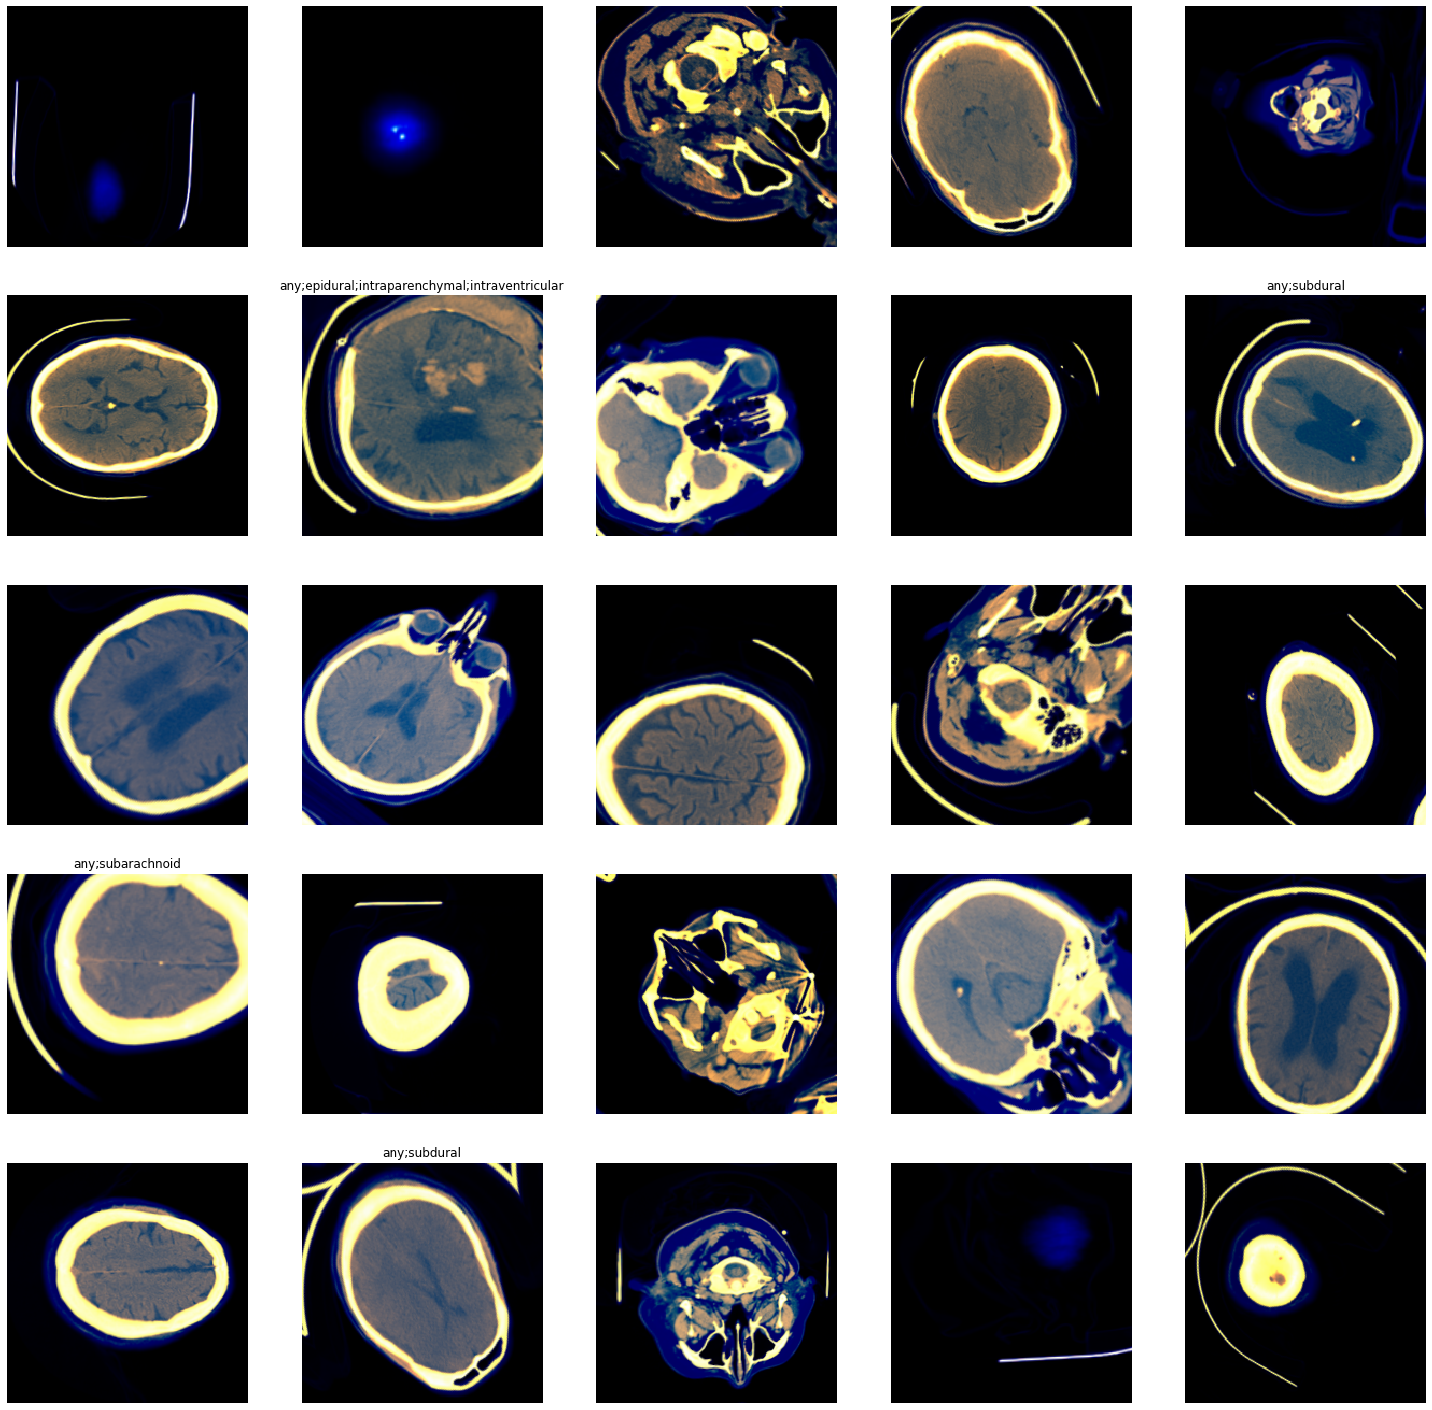

In [6]:
data.show_batch()

In [7]:
learn = Learner(data,
                    md_xrsa,
                    wd=1e-3,
                    bn_wd=False, 
                    true_wd=True, 
                    opt_func=opt_func,
                    metrics=[accuracy_thresh])

learn.model = nn.DataParallel(learn.model)
learn.to_fp16()
learn.unfreeze()

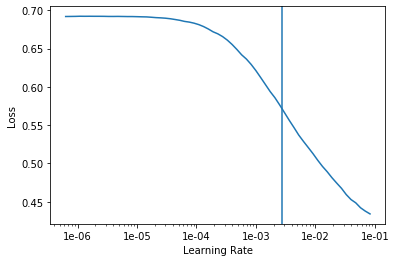

In [8]:
lr = 0.0028
learn.recorder.plot()
plt.axvline(lr)

In [ ]:
lr = 0.0028
flattenAnneal(learn, lr, 50, 0.68)

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.098423,0.104032,0.963713,21:20
1,0.086463,0.087162,0.969918,21:42
2,0.079898,0.077985,0.972657,22:07
3,0.078889,0.077777,0.972618,21:59
4,0.076275,0.073423,0.974227,21:21
5,0.072802,0.069736,0.975329,21:55
6,0.070730,0.072870,0.974674,22:16
7,0.070903,0.068964,0.975468,21:35
8,0.067187,0.065953,0.976533,21:39
9,0.066615,0.067458,0.975811,21:39


Better model found at epoch 0 with valid_loss value: 0.1040324717760086.
Better model found at epoch 1 with valid_loss value: 0.08716205507516861.
Better model found at epoch 2 with valid_loss value: 0.0779852420091629.
Better model found at epoch 3 with valid_loss value: 0.07777740061283112.
Better model found at epoch 4 with valid_loss value: 0.07342329621315002.
Better model found at epoch 5 with valid_loss value: 0.0697358101606369.
Better model found at epoch 7 with valid_loss value: 0.06896357238292694.
Better model found at epoch 8 with valid_loss value: 0.06595328450202942.
Better model found at epoch 10 with valid_loss value: 0.06546761840581894.
Better model found at epoch 11 with valid_loss value: 0.06449813395738602.
Better model found at epoch 12 with valid_loss value: 0.06414061784744263.
Better model found at epoch 13 with valid_loss value: 0.06363114714622498.
Better model found at epoch 14 with valid_loss value: 0.06222115084528923.
Better model found at epoch 17 with 

In [8]:
learn.load('NB_EXP_70_CV_6_224_PHASE_1_COS')

set state called


Learner(data=ImageDataBunch;

Train: LabelList (606836 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: MultiCategoryList
,,,,
Path: ..;

Valid: LabelList (67421 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: MultiCategoryList
,,,,
Path: ..;

Test: LabelList (78545 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: .., model=DataParallel(
  (module): MXResNet(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Mish()
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, aff

In [9]:
lr = 0.0028
flattenAnneal(learn, lr, 20, 0.20)

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.056548,0.059838,0.978639,21:31
1,0.055106,0.059626,0.978639,21:10
2,0.054065,0.057224,0.979737,22:27
3,0.054008,0.059196,0.979190,21:45
4,0.052249,0.057995,0.979537,21:50
5,0.050647,0.056383,0.980009,22:09
6,0.048935,0.057493,0.979868,21:06
7,0.047636,0.056028,0.980085,21:27
8,0.046105,0.053951,0.980832,22:17
9,0.043456,0.055036,0.980933,21:44


Better model found at epoch 0 with valid_loss value: 0.05983785539865494.
Better model found at epoch 1 with valid_loss value: 0.05962604656815529.
Better model found at epoch 2 with valid_loss value: 0.05722358077764511.
Better model found at epoch 5 with valid_loss value: 0.056382790207862854.
Better model found at epoch 7 with valid_loss value: 0.056027866899967194.
Better model found at epoch 8 with valid_loss value: 0.05395127832889557.
Better model found at epoch 11 with valid_loss value: 0.052677031606435776.
Better model found at epoch 13 with valid_loss value: 0.05184593051671982.
set state called


In [10]:

def get_preds(learn:Learner, sub_fn: str=f'{EXP_NAME}_PHASE_1_COS', TTA: bool = False, dt_type = DatasetType.Test):
    if TTA:
        learn.to_fp32()
        preds, targs = learn.TTA(ds_type=dt_type)
        sub_fn = f'{sub_fn}_TTA'
    else:
        preds, targs = learn.get_preds(dt_type)
    ids = []
    labels = []

    for fn, pred in zip(test_fns, preds):
        for i, label in enumerate(data.train_ds.classes):
            ids.append(f"{fn.split('.')[0]}_{label}")
            predicted_probability = '{0:1.10f}'.format(pred[i].item())
            labels.append(predicted_probability)
    pd.DataFrame({'ID': ids, 'Label': labels}).to_csv(f'{sub_fn}.csv', index=False)

In [11]:
get_preds(learn)

In [12]:
get_preds(learn, TTA=True)

In [14]:
!sudo shutdown -c

In [15]:
pred, y = learn.get_preds()

In [21]:
y = y.numpy()

In [19]:
pred = pred.numpy()


In [23]:
from sklearn.metrics import log_loss

In [35]:
sc = log_loss(y, pred, sample_weight= np.array([2, 1, 1, 1, 1, 1]))

ValueError: Found input variables with inconsistent numbers of samples: [67421, 67421, 6]

In [36]:
!sudo shutdown

Shutdown scheduled for Mon 2019-10-07 21:37:59 UTC, use 'shutdown -c' to cancel.
